In [1]:
# !pip install fastai
# !pip install transformers

In [2]:
from fastai.text.all import *
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

In [3]:
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
model = GPT2LMHeadModel.from_pretrained(pretrained_weights)

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x000001ECEE3A2C10>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/tokenizer_config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/vocab.json (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x000001ECEE422460>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/vocab.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.VerifiedHTTPSConnection object at 0x000001ECEE42F850>, 'Connection to hu

In [4]:
path = './poems'
# from google.colab import drive
# drive.mount('/content/drive')


In [5]:
# path="drive/MyDrive/poem/poems"
# !ls drive/MyDrive/poem/poems

In [6]:
poems = get_text_files(path, folders = ['haiku'])
print("There are",len(poems),"poems in the dataset")

There are 99 poems in the dataset


In [7]:
haiku = get_text_files(path, folders = ['haiku'])
print("There are",len(haiku),"haiku in the dataset")

There are 99 haiku in the dataset


In [8]:
txt = poems[0].open().read(); #read the first file
print(txt)

haiku one:
in criss-crossing shadows
of the mountains, we admire
sunbathed summits
haiku two:
in criss crossing shadows
we admire sunbathed
summits
haiku three:
tottering ballet dancer
the butterfly flutters
round a bloom
haiku three:
dead widow's bamboo bell
each chime echoes
a memory of her
dead widow's bamboo bell
each chime numbs
the mind
dead widow's bamboo bell
each chime echoes
a lonely year/her lonely years
haiku four;
dead widow's bamboo bell
forelorn the chime
has become
tanka:
dugout river
a nude doll stares
right through me
i discover stephen king and
- shiver


## Prepare the data

In [9]:
haiku = L(o.open().read() for o in haiku[:50]) # to make things easy we will gather all texts in one numpy array
haiku


(#50) ["haiku one:\nin criss-crossing shadows\nof the mountains, we admire\nsunbathed summits\nhaiku two:\nin criss crossing shadows\nwe admire sunbathed\nsummits\nhaiku three:\ntottering ballet dancer\nthe butterfly flutters\nround a bloom\nhaiku three:\ndead widow's bamboo bell\neach chime echoes\na memory of her\ndead widow's bamboo bell\neach chime numbs\nthe mind\ndead widow's bamboo bell\neach chime echoes\na lonely year/her lonely years\nhaiku four;\ndead widow's bamboo bell\nforelorn the chime\nhas become\ntanka:\ndugout river\na nude doll stares\nright through me\ni discover stephen king and\n- shiver","war memorial\nreccuring, late dad's words\nthat war is a shame\npeace march\ni wear late dad's peace ring\nfor the first time\ninspired by\nrose garden\nIâ€™ve forgotten which one\nis called Peace",'Iâ€™m down: <(hereâ€™s the news\nJust cause Iâ€™m whiteâ€¦ doesnâ€™t mean\nI canâ€™t get the blues',"The harvest soon comes\nA hawk's eye is needed now\nTwo watching a front","I'm h

In [10]:
def flatten(A):
    rt = []
    for i in A:
        if isinstance(i,list): rt.extend(flatten(i))
        else: rt.append(i)
    return rt
  
all_haiku = flatten(haiku)
len(all_haiku)

50

In [11]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer): self.tokenizer = tokenizer
    def encodes(self, x): 
        toks = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(toks))
    def decodes(self, x): return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [12]:
splits = [range_of(20), range(50)] # use a 70/30 split

tls = TfmdLists(all_haiku, TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)

In [13]:
show_at(tls.train, 0)

haiku one:
in criss-crossing shadows
of the mountains, we admire
sunbathed summits
haiku two:
in criss crossing shadows
we admire sunbathed
summits
haiku three:
tottering ballet dancer
the butterfly flutters
round a bloom
haiku three:
dead widow's bamboo bell
each chime echoes
a memory of her
dead widow's bamboo bell
each chime numbs
the mind
dead widow's bamboo bell
each chime echoes
a lonely year/her lonely years
haiku four;
dead widow's bamboo bell
forelorn the chime
has become
tanka:
dugout river
a nude doll stares
right through me
i discover stephen king and
- shiver


In [14]:
bs,sl = 4,256
dls = tls.dataloaders(bs=bs, seq_len=sl)

In [15]:
dls.show_batch(max_n=2)

,text,text_
0,"In the coolness\nof the empty sixth-month sky...\nthe cuckoo's cry.Spring:\nA hill without a name\nVeiled in morning mist.\nThe beginning of autumn:\nSea and emerald paddy\nBoth the same green.\nThe winds of autumn\nBlow: yet still green\nThe chestnut husks.\nA flash of lightning:\nInto the gloom\nGoes the heron's cry.\nTranslated by Geoffrey Bownas And Anthony ThwaiteThe harvest soon comes\nA hawk's eye is needed now\nTwo watching a frontspring\nbird song sweet\nas the flowers\nbeginning of autumn\na summer skin\ni still carry\nthe winds of autumn\nslowly the leaves wave\nthe season goodbye\na flash of lightning\nthe breeze steals\ninto my soulscatter layer\nby layer, eight-layered\ncherry blossoms!Big waves ten foot plus,\nFear fills my heart - board too small\nMaybe tomorrowone haiku a day\npeace of mindFields of green waves under\nThe sky grey, rain on the soft\nWinds whisper; normality reigns.at the full moon's\nrising, the silver-","the coolness\nof the empty sixth-month sky...\nthe cuckoo's cry.Spring:\nA hill without a name\nVeiled in morning mist.\nThe beginning of autumn:\nSea and emerald paddy\nBoth the same green.\nThe winds of autumn\nBlow: yet still green\nThe chestnut husks.\nA flash of lightning:\nInto the gloom\nGoes the heron's cry.\nTranslated by Geoffrey Bownas And Anthony ThwaiteThe harvest soon comes\nA hawk's eye is needed now\nTwo watching a frontspring\nbird song sweet\nas the flowers\nbeginning of autumn\na summer skin\ni still carry\nthe winds of autumn\nslowly the leaves wave\nthe season goodbye\na flash of lightning\nthe breeze steals\ninto my soulscatter layer\nby layer, eight-layered\ncherry blossoms!Big waves ten foot plus,\nFear fills my heart - board too small\nMaybe tomorrowone haiku a day\npeace of mindFields of green waves under\nThe sky grey, rain on the soft\nWinds whisper; normality reigns.at the full moon's\nrising, the silver-pl"
1,"iku two:\nin criss crossing shadows\nwe admire sunbathed\nsummits\nhaiku three:\ntottering ballet dancer\nthe butterfly flutters\nround a bloom\nhaiku three:\ndead widow's bamboo bell\neach chime echoes\na memory of her\ndead widow's bamboo bell\neach chime numbs\nthe mind\ndead widow's bamboo bell\neach chime echoes\na lonely year/her lonely years\nhaiku four;\ndead widow's bamboo bell\nforelorn the chime\nhas become\ntanka:\ndugout river\na nude doll stares\nright through me\ni discover stephen king and\n- shiverentangled with\nthe scattering cherry blossomsâ€”\nthe wings of birds!Waking in the night;\nthe lamp is low,\nthe oil freezing.\nIt has rained enough\nto turn the stubble on the field\nblack.\nWinter rain\nfalls on the cow-shed;\na cock crows.\nThe leeks\nnewly washed white,-\nhow cold it is!\nThe sea darkens;\nthe voices of the wild ducks\nare faintly white.\nIll on a journey;\n","two:\nin criss crossing shadows\nwe admire sunbathed\nsummits\nhaiku three:\ntottering ballet dancer\nthe butterfly flutters\nround a bloom\nhaiku three:\ndead widow's bamboo bell\neach chime echoes\na memory of her\ndead widow's bamboo bell\neach chime numbs\nthe mind\ndead widow's bamboo bell\neach chime echoes\na lonely year/her lonely years\nhaiku four;\ndead widow's bamboo bell\nforelorn the chime\nhas become\ntanka:\ndugout river\na nude doll stares\nright through me\ni discover stephen king and\n- shiverentangled with\nthe scattering cherry blossomsâ€”\nthe wings of birds!Waking in the night;\nthe lamp is low,\nthe oil freezing.\nIt has rained enough\nto turn the stubble on the field\nblack.\nWinter rain\nfalls on the cow-shed;\na cock crows.\nThe leeks\nnewly washed white,-\nhow cold it is!\nThe sea darkens;\nthe voices of the wild ducks\nare faintly white.\nIll on a journey;\nmy"


## Fine-tuning the model

In [16]:
class DropOutput(Callback):
    def after_pred(self): self.learn.pred = self.pred[0]

In [17]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()

In [18]:
learn.validate()

c:\Users\shelk\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\amp\autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
c:\Users\shelk\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\cuda\amp\grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


(#2) [4.835131645202637,125.85514831542969]

SuggestedLRs(valley=0.0003311311302240938)

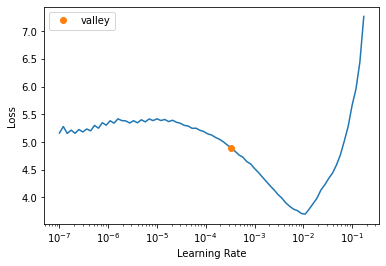

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(1, 1e-4)

epoch,train_loss,valid_loss,perplexity,time
0,5.350801,4.733028,113.639137,00:28


## Poem Generation

In [21]:
prompt = 'love is ridiculous' # create an initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]

In [22]:
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
love is ridiculous."

"I don't know what you're talking about," she said. "I mean, it's not like I'm going to be able to do anything about it. It's like, 'Oh, I can't do this. I've got to get out of


In [23]:
prompt = ""
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
preds = learn.model.generate(inp, max_length=60, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
heartbreak.com

http://www.mike.co.uk/en/news/local-news-and-politics/article/20140509/The-Crown-of-the-Mountain-Dwellers.html


The Crown of the Mountain D


In [27]:
import pickle

In [28]:
filename = "haiku.sav"
pickle.dump(learn.model, open(filename, "wb"))

In [29]:
model_saved = pickle.load(open(filename, "rb"))
model_saved

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

In [55]:
prompt = "I hope she is the one"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
preds = model_saved.generate(inp, max_length=30, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I hope she is the one who is going to get the job done.

"I'm not sure if she will be able to do it


In [62]:
prompt = "johny johny yes papa"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None]
preds = model_saved.generate(inp, max_length=50, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
johny johny yes papa johnny yes johnnie johnson johns johnsen johnston johnswain johnweber johnwhitney johnwyck johnye johnyo johnzoe johnze johnzo johnza johnzx johnzy


In [61]:
prompt = "beach"
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None] 
preds = model_saved.generate(inp, max_length=50, num_beams=5, no_repeat_ngram_size=2, early_stopping=True)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
beach.

"I think it's a good idea," he said. "I don't know if I'm going to be able to do it, but I've got a lot of work ahead of me and I think I can do
